### Debug environment for the MARL process

In [1]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from utils.train_test_methods import *
from utils.params import *
from utils.retrieve_sim import *

from importlib import reload
import utils

input_type = U_VELOCITY
observe_type = O_VELOCITY
observe_action = O_ACTION
reward_mode=ALL_REWARD

import os
try:
    os.mkdir('screencaps')
except:
    pass


In [103]:
# Load the model and make the right environment
reload(utils.agents)
from utils.agents import *
num_episode=500#250#500
test_interval=10#0
num_test=10#50
num_iteration=200
BATCH_SIZE=128#64#128
save_sim_intv=50
debug=False
num_sample=50
seed=22222
hidden=32
action_space=[-1,1]

# rand_mode = NO_RAND
rand_mode = GAUSS_RAND
N = 2
env = gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N, dt=0.1, Delta=0.05, #o_radius=40000,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=DIST_REWARD,
                 boundary_policy=SOFT_PENALTY, finish_reward_policy=REWARD_IF_CONSENSUS, 
                 uses_boundary=False
#                  uses_boundary=True
        ).unwrapped
agent = AC2Agent(device, env.N, env.nf, env.na, hidden, rand_modeA=rand_mode,
                 learning_rateA=0.01, learning_rateC=0.02, mode=1208)
agent.load_model('models/AC2Agent_AC2_dist_reward_posGauss_fixed0_m1208_soft_bound_cumu_posReward_N2_749')
steps = 0

Loading model from models/AC2Agent_AC2_dist_reward_posGauss_fixed0_m1208_soft_bound_cumu_posReward_N2_749


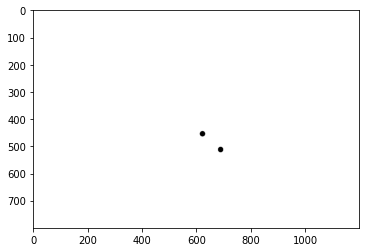

In [104]:
# Copy the code from train and test functions, and prepare to run it
agent.set_train(False)
cum_reward = 0
reward_hist = []

state = env.reset()
if agent.centralized:
    state = env.state
state = torch.from_numpy(state).float()
state = Variable(state)

img = env.render(mode="rgb_array")
env.close()
plt.imshow(img)

Current env state: (loc in x, loc in y, vel in x, vel in y) 
 [[ 0.          0.17738344]
 [ 0.         -0.15457512]
 [ 0.99999988  0.99999988]
 [-0.99999982 -0.99999988]] 
 Observed state: (4x relative states, 2x self and neighbor actions, 1x time count)
 [[[ 0.00000000e+00 -1.77383442e-01]
  [ 0.00000000e+00  1.54575116e-01]
  [ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  5.96046448e-08]
  [ 9.99999881e-01  9.99999881e-01]
  [-9.99999821e-01 -9.99999881e-01]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 1.77383442e-01  0.00000000e+00]
  [-1.54575116e-01  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]
  [-5.96046448e-08  0.00000000e+00]
  [ 9.99999881e-01  9.99999881e-01]
  [-9.99999821e-01 -9.99999881e-01]
  [ 0.00000000e+00  0.00000000e+00]]] 
Reward: 
 [-94.1134224 -94.1134224]


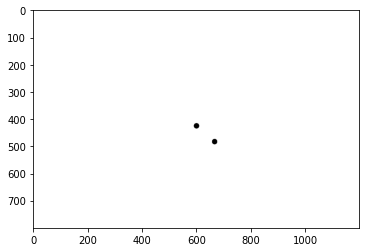

In [105]:
# Copy the code from train and test functions, and run it iteration by iteration
with torch.no_grad():  
    # Try to pick an action, react, and store the resulting behavior in the pool here
    if agent.centralized:
        action = agent.select_action(state, **{
                'steps_done':steps, 'rand':False, 'num_sample':50, 'action_space':action_space
            }).T
    else:
        actions = []
        for i in range(N):
            action = agent.select_action(state[i], **{
                'steps_done':steps, 'rand':False, 'num_sample':50, 'action_space':action_space
            })
            actions.append(action)
        action = np.array(actions).T 

    next_state, reward, done, _ = env.step(action)
    img = env.render(mode="rgb_array")
    env.close()
    plt.imshow(img)
    
    if agent.centralized:
        next_state = env.state
    print("Current env state: (loc in x, loc in y, vel in x, vel in y) \n", env.state[:4], 
          "\n Observed state: (4x relative states, 2x self and neighbor actions, 1x time count)\n", next_state, 
          "\nReward: \n", reward)
    
    next_state = Variable(torch.from_numpy(next_state).float()) # The float() probably avoids bug in net.forward()
    state = next_state
    cum_reward += sum(reward)
    reward_hist.append(reward)
    steps += 1

    if done:
        print("Took ", steps, " steps to converge")
        

In [106]:
env.Adj

array([[0., 1.],
       [1., 0.]])

In [111]:
diff = env.state.T.reshape((env.N,env.ns,1)) - env.state.reshape((1,env.ns,env.N))

diff_norm = np.linalg.norm(diff[:,:2,:], ord=2, axis=1)

diff_norm

array([[0.        , 0.23528356],
       [0.23528356, 0.        ]])

In [108]:
action

array([[ 0.9999999,  0.9999999],
       [-0.9999998, -0.9999999]], dtype=float32)

In [107]:
env.state

array([[ 0.        ,  0.17738344],
       [ 0.        , -0.15457512],
       [ 0.99999988,  0.99999988],
       [-0.99999982, -0.99999988],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])

In [110]:
act_params = agent.netA(Variable(next_state[1].view(1, -1, N)))
act_params

tensor([[ 1., -1.,  1.,  1.]], grad_fn=<CatBackward>)

In [95]:
pred_action = torch.zeros(1,agent.na)
pred_probs = torch.zeros(1)

distrb = torch.distributions.Normal(
    act_params[:,:agent.na],
    torch.diag( nn.functional.softplus( act_params[:,agent.na:] ) )
)
aa = distrb.sample()
aa

tensor([[ 0.7810, -1.2545]])

In [96]:
pred_action = torch.clamp( aa, agent.action_range[0], agent.action_range[1] )
pred_probs = distrb.log_prob(pred_action)
pred_action, pred_probs

(tensor([[ 0.7810, -1.0000]]),
 tensor([[-1.2054, -1.1915]], grad_fn=<SubBackward0>))

In [90]:
nn.functional.softplus( act_params[:,agent.na:] )

tensor([[1.3133, 1.3133]], grad_fn=<SoftplusBackward>)

In [91]:
aa = distrb.sample()
aa

tensor([[-0.4820, -2.4129]])

In [92]:
torch.clamp( aa, agent.action_range[0], agent.action_range[1] )

tensor([[-0.4820, -1.0000]])

In [102]:
agent.rand_modeA

2

In [108]:
# Test out centralized environment
reload(utils.ReplayMemory)
reload(utils.networks)
reload(utils.agents)
reload(utils.plotting)
reload(utils.train_test_methods)
from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from utils.train_test_methods import *

num_episode=2#00#250#500
test_interval=1#0#0
num_test=1#0#50
num_iteration=20#0
BATCH_SIZE=4#8#64#128
save_sim_intv=50
debug=False
num_sample=50
seed=22222
hidden=32
action_space=[-1,1]

# rand_mode = NO_RAND
rand_mode = GAUSS_RAND

N_list = [3]
env_list = []
for N_ in N_list:
    env_list.append(
        gym.make('ConsensusEnv:CentralizedConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05, #o_radius=40000,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, 
                 reward_mode=DIST_REWARD,#|ACT_REWARD,
#                  uses_boundary=True,
                 uses_boundary=False,
                 dist_reward_func=lambda x : (np.abs(x) + 2) * (np.abs(x) + 2),
                 boundary_policy=SOFT_PENALTY, finish_reward_policy=REWARD_IF_CONSENSUS
        ).unwrapped
    )
#     env_list[-1].mov_w = 100

AC2_list = []
for i,N_ in enumerate(N_list):
    AC2_list.append(
        AC2Agent(device, N_, env_list[i].ns, # IMPORTANT!!! use .ns for centralized, and .nf for decentralized
                 env_list[i].na, hidden, rand_modeA=rand_mode, centralized=True,
                 learning_rateA=0.01, learning_rateC=0.02, mode=1208)
    )

sim_fnames = ['AC2_centralizedTest_m1208_N{0}'.format(N_) for N_ in N_list]
memory_backup = []
AC2_hist = []
AC2_loss = []
for i,N_ in enumerate(N_list):
    AC2_loss.append([])
    memory_backup.append( ReplayMemory(1000 * env_list[i].N) )
    AC2_hist.append(
        train(AC2_list[i], env_list[i], 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug, memory=memory_backup[-1],
#               update_mode=UPDATE_PER_ITERATION, reward_mode=FUTURE_REWARD_YES_NORMALIZE, 
              update_mode=UPDATE_PER_EPISODE, reward_mode=FUTURE_REWARD_YES|FUTURE_REWARD_NORMALIZE,
              loss_history=AC2_loss[i],
              save_sim_intv=save_sim_intv, save_sim_fnames=[sim_fnames[i]], 
              imdir='screencaps/', useVid=False)
    )
    print("Finished training env with {0} agents for AC".format(N_))


Updated mean and stdev: -180041.41997785214 and 91282.13883207772
Test result at episode  0 : 
Test result at episode  1 : 
Finished training env with 3 agents for AC


In [185]:
reload(utils.ReplayMemory)
reload(utils.networks)
reload(utils.agents)
reload(utils.plotting)
reload(utils.train_test_methods)
from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from utils.train_test_methods import *

num_episode=2000#500#250#500
test_interval=10*2#0
num_test=10#10#50
num_iteration=200
BATCH_SIZE=2*128#64#128
save_sim_intv=50*2*4
debug=False
num_sample=50
seed=22222
hidden=32
action_space=[-1,1]

# rand_mode = NO_RAND
rand_mode = GAUSS_RAND

N_list = [3]
env_list = []
for N_ in N_list:
    env_list.append(
        gym.make('ConsensusEnv:CentralizedConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05, #o_radius=40000,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, 
                 reward_mode=DIST_REWARD,#|ACT_REWARD,
#                  uses_boundary=True,
                 uses_boundary=False,
                 dist_reward_func=lambda x : (np.log(np.abs(x)+1)),
#                  dist_reward_func=lambda x : np.sqrt(np.abs(x)),
#                  dist_reward_func=lambda x : (np.abs(x) + 2) * (np.abs(x) + 2), # * (np.abs(x) + 2) * (np.abs(x) + 2),
                 boundary_policy=SOFT_PENALTY, finish_reward_policy=REWARD_IF_CONSENSUS
        ).unwrapped
    )
#     env_list[-1].mov_w = 100

AC2_list = []
for i,N_ in enumerate(N_list):
    AC2_list.append(
        AC2Agent(device, N_, env_list[i].ns, # IMPORTANT!!! use .ns for centralized, and .nf for decentralized
                 env_list[i].na, hidden, rand_modeA=rand_mode, centralized=True,
                 neg_loss_sign=True,#False,
                 learning_rateA=0.01, learning_rateC=0.02, mode=12088)
    )

sim_fnames = ['AC2_centralizedTest_logreward_tanhC_leak03A_m0_N{0}'.format(N_) for N_ in N_list]
memory_backup = []
AC2_hist = []
AC2_loss = []
for i,N_ in enumerate(N_list):
    AC2_loss.append([])
    memory_backup.append( ReplayMemory(1000 * env_list[i].N) )
    AC2_hist.append(
        train(AC2_list[i], env_list[i], 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug, memory=memory_backup[-1],
              update_mode=UPDATE_PER_EPISODE, #UPDATE_PER_ITERATION,
              reward_mode=FUTURE_REWARD_NORMALIZE,
#               reward_mode=FUTURE_REWARD_YES,#|FUTURE_REWARD_NORMALIZE, #FUTURE_REWARD_YES_NORMALIZE, 
              loss_history=AC2_loss[i], #reward_mean_var=(torch.Tensor([-69600]), torch.Tensor([46290])),
              save_sim_intv=save_sim_intv, save_sim_fnames=[sim_fnames[i]], 
              imdir='screencaps/', useVid=False)
    )
    print("Finished training env with {0} agents for AC".format(N_))


Updated mean and stdev: -2943.672438949014 and 933.7362945617103
Test result at episode  0 : 
Test result at episode  20 : 
Test result at episode  40 : 
Test result at episode  60 : 
Test result at episode  80 : 
Test result at episode  100 : 
Test result at episode  120 : 
Test result at episode  140 : 
Test result at episode  160 : 
Test result at episode  180 : 
Test result at episode  200 : 
Test result at episode  220 : 
Test result at episode  240 : 
Test result at episode  260 : 
Test result at episode  280 : 
Test result at episode  300 : 
Test result at episode  320 : 
Test result at episode  340 : 
Test result at episode  360 : 
Test result at episode  380 : 
Finished episode  0  with  199 ;
cumulative reward =  -1087704.0930200182
Test result at episode  400 : 
Test result at episode  420 : 
Test result at episode  440 : 
Test result at episode  460 : 
Test result at episode  480 : 
Test result at episode  500 : 
Test result at episode  520 : 
Test result at episode  540 : 

<Figure size 432x288 with 0 Axes>

In [142]:
# More training
reward_mean_var = (torch.Tensor([-77885.03781972894]), torch.Tensor([38672.516062239236]))
sim_fnames = ['AC2_centralizedTest__m0_N{0}'.format(N_) for N_ in N_list]
for i,N_ in enumerate(N_list):
    AC2_hist[i] += train(AC2_list[i], env_list[i], 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug, memory=memory_backup[i],
              update_mode=UPDATE_PER_EPISODE, #UPDATE_PER_ITERATION,
              reward_mode=FUTURE_REWARD_NORMALIZE,
#               reward_mode=FUTURE_REWARD_YES,#|FUTURE_REWARD_NORMALIZE, #FUTURE_REWARD_YES_NORMALIZE, 
              loss_history=AC2_loss[i], reward_mean_var=reward_mean_var,
              save_sim_intv=save_sim_intv, save_sim_fnames=[sim_fnames[i]], 
              imdir='screencaps/', useVid=False)
    print("Finished training env with {0} agents for AC".format(N_))


Test result at episode  0 : 
Test result at episode  10 : 
Test result at episode  20 : 
Test result at episode  30 : 
Test result at episode  40 : 
Test result at episode  50 : 
Test result at episode  60 : 
Test result at episode  70 : 
Test result at episode  80 : 
Test result at episode  90 : 
Test result at episode  100 : 
Test result at episode  110 : 
Test result at episode  120 : 
Test result at episode  130 : 
Test result at episode  140 : 
Test result at episode  150 : 
Test result at episode  160 : 
Test result at episode  170 : 
Test result at episode  180 : 
Test result at episode  190 : 
Finished episode  0  with  199 ;
cumulative reward =  -71448492.71058755
Test result at episode  200 : 
Test result at episode  210 : 
Test result at episode  220 : 
Test result at episode  230 : 
Test result at episode  240 : 
Test result at episode  250 : 
Test result at episode  260 : 
Test result at episode  270 : 
Test result at episode  280 : 
Test result at episode  290 : 
Test res

<Figure size 432x288 with 0 Axes>

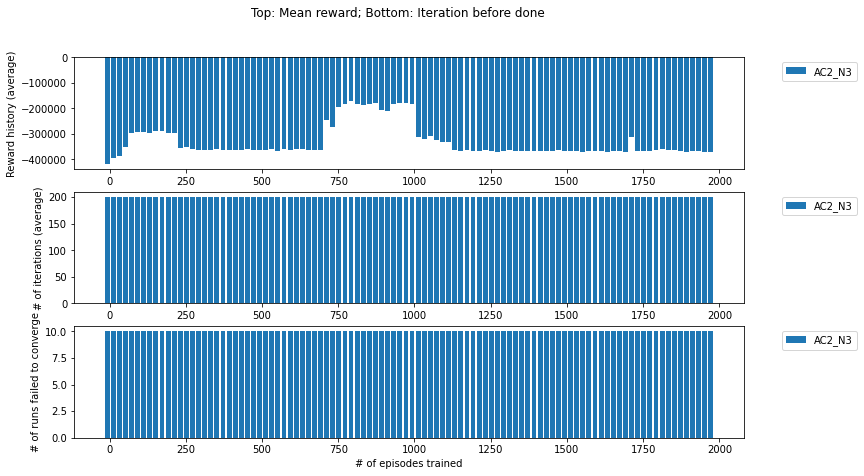

In [186]:
skip=1
plot_reward_hist([h[::skip] for h in AC2_hist], test_interval*skip, 
                 ['AC2_N{0}'.format(N_) for N_ in N_list], 
                 log=False, num_iteration=num_iteration, N_list=([N for N in N_list]), bar=True)

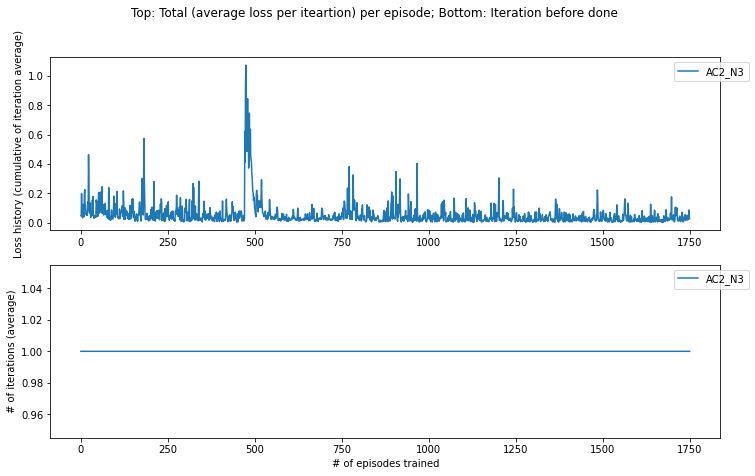

In [187]:
skip=1
plot_loss_hist(hists=[h[250::skip] for h in AC2_loss], hist_names=['AC2_N{0}'.format(N_) for N_ in N_list], log=False, 
               num_iteration=num_iteration, update_mode=UPDATE_PER_ITERATION, bar=False)

In [184]:
AC2_list[0].save_model('AC2_centralizedTest_logreward_leaky03AC_e2000_m0_rmean-1592_rstdev645_N3')

Saving model to models/AC2Agent_AC2_centralizedTest_logreward_leaky03AC_e2000_m0_rmean-1592_rstdev645_N3


In [ ]:
# reload(utils.plotting)
# from utils.plotting import *
plot_test(AC2_list[0], env_list[0], fnames=['AC2_centralizedTest_c01_N3'],
        num_iteration=100, action_space=action_space, imdir='screencaps/',debug=debug, 
          not_use_rand=True)

In [55]:
print("Last  layer Actor gradients after backward: ", torch.mean(AC2_list[i].netA.ANlayers[0].weight.grad))
print("Mid   layer Actor gradients after backward: ", torch.mean(AC2_list[i].netA.ANlayers[2].weight.grad))
print("Front layer Actor gradients after backward: ", torch.mean(AC2_list[i].netA.ANlayers[4].weight.grad))

Last  layer Actor gradients after backward:  tensor(0.0001)
Mid   layer Actor gradients after backward:  tensor(-3.1980e-05)
Front layer Actor gradients after backward:  tensor(-0.0058)


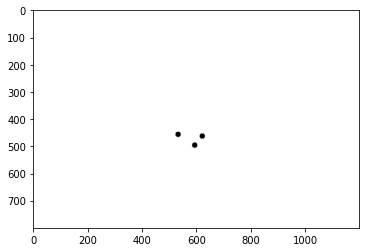

In [57]:
# Copy the code from train and test functions, and prepare to run it
agent = AC2_list[0]
env = env_list[0]
steps=0
agent.set_train(False)
cum_reward = 0
reward_hist = []

state = env.reset()
if agent.centralized:
    state = env.state
state = torch.from_numpy(state).float()
state = Variable(state)

img = env.render(mode="rgb_array")
env.close()
plt.imshow(img)

Current env state: (loc in x, loc in y, vel in x, vel in y) 
 [[ 0.          0.21773601  0.34361429]
 [ 0.         -0.21629022 -0.30499561]
 [-0.80893409 -1.          1.        ]
 [ 1.         -1.         -1.        ]] 
 Observed state: (4x relative states, 2x self and neighbor actions, 1x time count)
 [[ 0.          0.21773601  0.34361429]
 [ 0.         -0.21629022 -0.30499561]
 [-0.80893409 -1.          1.        ]
 [ 1.         -1.         -1.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]] 
Reward: 
 -17608.30766285311


TypeError: 'numpy.float64' object is not iterable

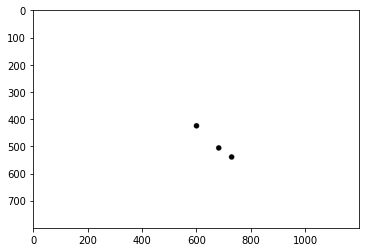

In [59]:
# Copy the code from train and test functions, and run it iteration by iteration
with torch.no_grad():  
    # Try to pick an action, react, and store the resulting behavior in the pool here
    if agent.centralized:
        action = agent.select_action(state, **{
                'steps_done':steps, 'rand':False, 'num_sample':50, 'action_space':action_space
            }).T
    else:
        actions = []
        for i in range(N):
            action = agent.select_action(state[i], **{
                'steps_done':steps, 'rand':False, 'num_sample':50, 'action_space':action_space
            })
            actions.append(action)
        action = np.array(actions).T 

    next_state, reward, done, _ = env.step(action)
    img = env.render(mode="rgb_array")
    env.close()
    plt.imshow(img)
    
    if agent.centralized:
        next_state = env.state
    print("Current env state: (loc in x, loc in y, vel in x, vel in y) \n", env.state[:4], 
          "\n Observed state: (4x relative states, 2x self and neighbor actions, 1x time count)\n", next_state, 
          "\nReward: \n", reward)
    
    next_state = Variable(torch.from_numpy(next_state).float()) # The float() probably avoids bug in net.forward()
    state = next_state
    cum_reward += reward
    reward_hist.append(reward)
    steps += 1

    if done:
        print("Took ", steps, " steps to converge")
        

In [106]:
env.Adj

array([[0., 1.],
       [1., 0.]])

In [108]:
action

array([[ 0.9999999,  0.9999999],
       [-0.9999998, -0.9999999]], dtype=float32)

In [107]:
env.state

array([[ 0.        ,  0.17738344],
       [ 0.        , -0.15457512],
       [ 0.99999988,  0.99999988],
       [-0.99999982, -0.99999988],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])

In [110]:
act_params = agent.netA(Variable(next_state[1].view(1, -1, N)))
act_params

tensor([[ 1., -1.,  1.,  1.]], grad_fn=<CatBackward>)

In [95]:
pred_action = torch.zeros(1,agent.na)
pred_probs = torch.zeros(1)

distrb = torch.distributions.Normal(
    act_params[:,:agent.na],
    torch.diag( nn.functional.softplus( act_params[:,agent.na:] ) )
)
aa = distrb.sample()
aa

tensor([[ 0.7810, -1.2545]])

In [96]:
pred_action = torch.clamp( aa, agent.action_range[0], agent.action_range[1] )
pred_probs = distrb.log_prob(pred_action)
pred_action, pred_probs

(tensor([[ 0.7810, -1.0000]]),
 tensor([[-1.2054, -1.1915]], grad_fn=<SubBackward0>))

In [90]:
nn.functional.softplus( act_params[:,agent.na:] )

tensor([[1.3133, 1.3133]], grad_fn=<SoftplusBackward>)

In [91]:
aa = distrb.sample()
aa

tensor([[-0.4820, -2.4129]])

In [92]:
torch.clamp( aa, agent.action_range[0], agent.action_range[1] )

tensor([[-0.4820, -1.0000]])

In [102]:
agent.rand_modeA

2

In [6]:
np.ones((env_list[0].N,1,env_list[0].N))

array([[[1., 1., 1.]],

       [[1., 1., 1.]],

       [[1., 1., 1.]]])

In [11]:
env_list[0].filter_neighbor_actions(np.zeros((2,3)))

TypeError: data type not understood

In [136]:
memory_backup[0].memory[0:10]

[Transition(state=tensor([[  0.0000,  -0.4797,  -6.2901],
         [  0.0000, -35.3566,   0.0634],
         [  0.9411,   1.0000,   0.2920],
         [  1.0000,  -1.0000,   0.9325],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000]]), action=array([[ 1.       ,  1.       ],
        [ 1.       , -1.       ],
        [-0.6322727,  1.       ]], dtype=float32), next_state=tensor([[  0.0000,  -0.4797,  -6.4533],
         [  0.0000, -35.5566,   0.0634],
         [  1.0000,   1.0000,  -0.6323],
         [  1.0000,  -1.0000,   1.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000]]), reward=tensor(-37.4956, dtype=torch.float64)),
 Transition(state=tensor([[  0.0000,  -0.4856,  -6.2252],
         [  0.0000, -35.1566,   0.0702],
         [  1.0000,   0.2098,  -0.3413],
         [  0.9337,  -1.0000,   0.6256],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000]]), action=array([[ 0.9410733 ,  1.        ]

In [11]:
newstuff = env_list[0].reset()

In [94]:
len(torch.tensor([]))

0